# **STEP 17.5:** Machine Learning Model #5 - Decision Tree

In [1]:
import pandas as pd
import random as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve

import warnings
warnings.filterwarnings("ignore")

### Isodose + ROI - Delta Radiomics + Clinical Features

In [2]:
absolute_data_isodose_roi = pd.read_csv("/notebooks/disk2/CSV_Dataset/07_RF_Treatment_Clinical.csv")

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"2nd Treatment": 1})
)

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"Follow-up": 0})
)

X = absolute_data_isodose_roi.drop(columns=['Patient ID', 'Mask Name','Decision', 'First Treatment', 'First Follow-Up'])
y = absolute_data_isodose_roi["Decision"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("-------")
print(X.shape)
print(y.value_counts())
print("-------")

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)


X_encoded = preprocessor.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y #VMA
)

print("-------")
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}\n")
print(f"Train Distribution:\n{pd.value_counts(y_train)}\n")
print(f"Test Distribution:\n{pd.value_counts(y_test)}")
print("-------")


-------
(177, 1326)
Decision
1    132
0     45
Name: count, dtype: int64
-------
-------
Training set: (141, 1339), Test set: (36, 1339)

Train Distribution:
Decision
1    105
0     36
Name: count, dtype: int64

Test Distribution:
Decision
1    27
0     9
Name: count, dtype: int64
-------


### Define best parameters

Primeiro, antes de treinarmos o modelo, precisamos de perceber quais são os melhores parâmetros do modelo para conseguir obter os melhores resultados possíveis! Desta forma, utilizamos o RandomizedSearchCV que, por sua vez, utiliza o Cross Validation com 100 iterações para fazer hyper tuning. Utilizamos também test_size = 0.2, pela amostra de dados ser muito pequena.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best CV Score (F1): 0.9658196256381167
Train Accuracy: 0.9929
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.99      1.00      1.00       105

    accuracy                           0.99       141
   macro avg       1.00      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141

Confusion Matrix (Train):
 [[ 35   1]
 [  0 105]]


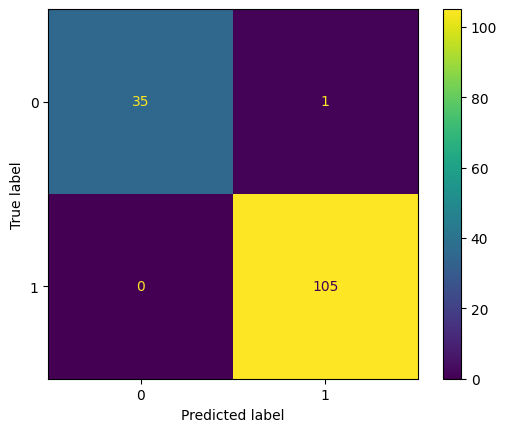

In [6]:
param_dist = {
    'criterion': ['gini', 'entropy'],         
    'max_depth': [3, 5, 6, 8, 10, None],      
    'min_samples_split': [2, 5, 10, 20],      
    'min_samples_leaf': [1, 2, 5, 10],        
    'class_weight': [None, 'balanced']        }

dt_model = tree.DecisionTreeClassifier(random_state=42)

# Set up the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='f1',   
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (F1):", random_search.best_score_)

best_dt = random_search.best_estimator_
y_pred = best_dt.predict(x_train)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred):.4f}")
print("Classification Report (Train):\n", classification_report(y_train, y_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred))

ConfusionMatrixDisplay.from_estimator(best_dt, x_train, y_train)
plt.show()

Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.96      0.93      0.94        27

    accuracy                           0.92        36
   macro avg       0.88      0.91      0.89        36
weighted avg       0.92      0.92      0.92        36

Confusion Matrix:
 [[ 8  1]
 [ 2 25]]


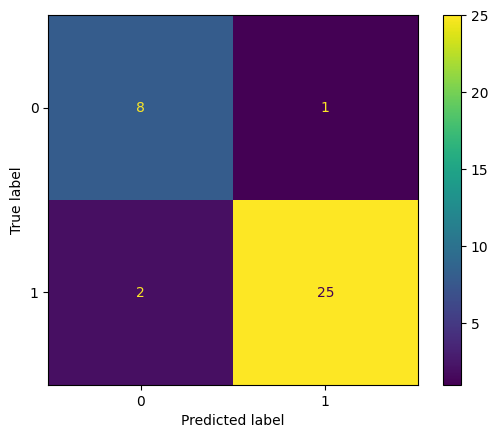

In [8]:
y_pred = best_dt.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_dt, x_test, y_test)
plt.show()

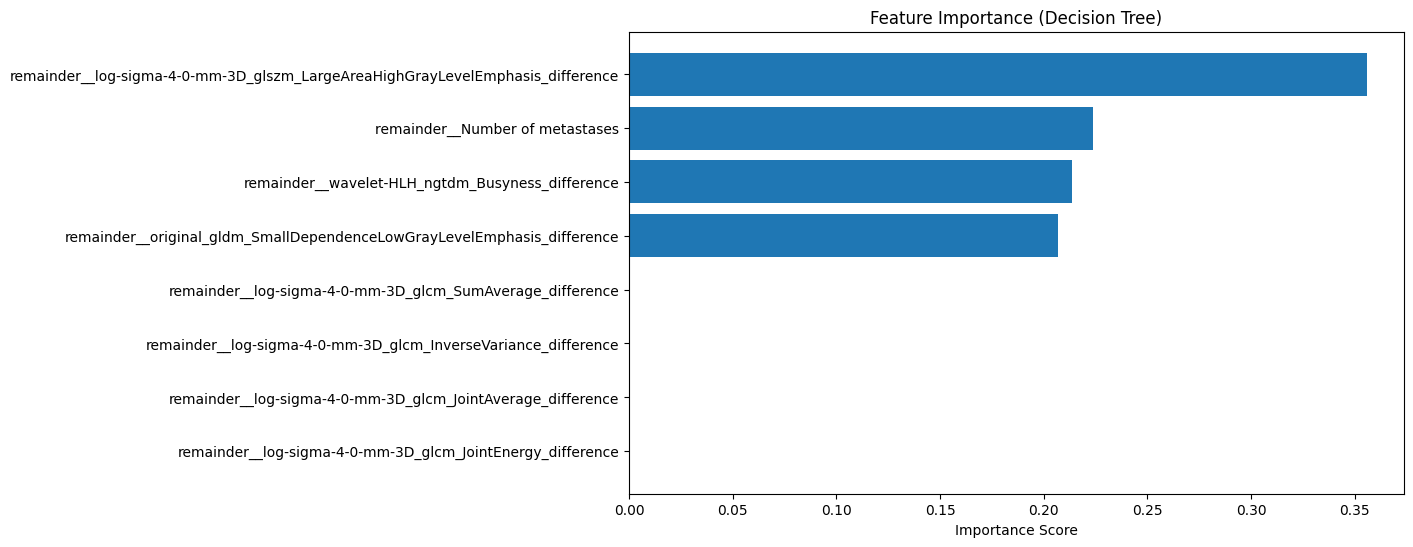

In [11]:
feature_names = preprocessor.get_feature_names_out()
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Decision Tree)")
plt.barh(range(8), importances[indices][:8], align="center")
plt.yticks(range(8), feature_names[indices][:8])
plt.gca().invert_yaxis() 
plt.xlabel("Importance Score")
plt.show()